In [1]:

import chess.engine
import pandas as pd
import os
import re

import chess.pgn
from collections import defaultdict

In [2]:
#read in "2025 FIDE World Cup" from folder
# Open the PGN file
pgn_file = open("2024-fide-candidates-chess-tournament.pgn", encoding="utf-8")

game_count = 0
for game in iter(lambda: chess.pgn.read_game(pgn_file), None):
    game_count += 1
    print(f"--- Game {game_count} ---")
    print(f"Event: {game.headers['Event']}")
    print(f"Result: {game.headers['Result']}")

# Close the file when finished
pgn_file.close()

--- Game 1 ---
Event: Candidates
Result: 1/2-1/2
--- Game 2 ---
Event: Candidates
Result: 1/2-1/2
--- Game 3 ---
Event: Candidates
Result: 1/2-1/2
--- Game 4 ---
Event: Candidates
Result: 1/2-1/2
--- Game 5 ---
Event: Candidates
Result: 0-1
--- Game 6 ---
Event: Candidates
Result: 0-1
--- Game 7 ---
Event: Candidates
Result: 1-0
--- Game 8 ---
Event: Candidates
Result: 1-0
--- Game 9 ---
Event: Candidates
Result: 1/2-1/2
--- Game 10 ---
Event: Candidates
Result: 1/2-1/2
--- Game 11 ---
Event: Candidates
Result: 1/2-1/2
--- Game 12 ---
Event: Candidates
Result: 0-1
--- Game 13 ---
Event: Candidates
Result: 1/2-1/2
--- Game 14 ---
Event: Candidates
Result: 1-0
--- Game 15 ---
Event: Candidates
Result: 1/2-1/2
--- Game 16 ---
Event: Candidates
Result: 1/2-1/2
--- Game 17 ---
Event: Candidates
Result: 1/2-1/2
--- Game 18 ---
Event: Candidates
Result: 0-1
--- Game 19 ---
Event: Candidates
Result: 1-0
--- Game 20 ---
Event: Candidates
Result: 1/2-1/2
--- Game 21 ---
Event: Candidates
Result:

In [7]:


def parse_clock_time(clk_str):
    """Convert clock string like '1:59:58' to seconds"""
    parts = clk_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(int, parts)
        return minutes * 60 + seconds
    return 0

def analyze_opening_time(pgn_file):
    """Analyze time spent in first 10 moves by each player"""
    
    # Dictionary to store time spent: player_name -> {total_time, white_time, black_time, games_as_white, games_as_black}
    player_stats = defaultdict(lambda: {
        'total_time': 0,
        'white_time': 0,
        'black_time': 0,
        'games_as_white': 0,
        'games_as_black': 0
    })
    
    INITIAL_TIME = 120 * 60  # 120 minutes in seconds
    
    with open(pgn_file) as f:
        game_count = 0
        
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            
            game_count += 1
            white_player = game.headers.get("White", "Unknown")
            black_player = game.headers.get("Black", "Unknown")
            
            # Track time spent by each player in first 10 moves
            white_time_spent = 0
            black_time_spent = 0
            
            board = game.board()
            move_count = 0
            
            for node in game.mainline():
                move_count += 1
                if move_count > 20:  # 10 moves each side
                    break
                
                # Get the clock comment
                if node.comment:
                    # Look for [%clk ...] pattern
                    if '%clk' in node.comment:
                        clk_start = node.comment.find('[%clk ') + 6
                        clk_end = node.comment.find(']', clk_start)
                        if clk_start > 5 and clk_end > clk_start:
                            clock_str = node.comment[clk_start:clk_end]
                            remaining_time = parse_clock_time(clock_str)
                            time_spent = INITIAL_TIME - remaining_time
                            
                            # Odd moves are white, even moves are black
                            if move_count % 2 == 1:  # White's move
                                white_time_spent = time_spent
                            else:  # Black's move
                                black_time_spent = time_spent
            
            # Update player statistics
            player_stats[white_player]['total_time'] += white_time_spent
            player_stats[white_player]['white_time'] += white_time_spent
            player_stats[white_player]['games_as_white'] += 1
            
            player_stats[black_player]['total_time'] += black_time_spent
            player_stats[black_player]['black_time'] += black_time_spent
            player_stats[black_player]['games_as_black'] += 1
    
    return player_stats, game_count

def format_time(seconds):
    """Convert seconds to HH:MM:SS format"""
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours}:{minutes:02d}:{secs:02d}"

# Main analysis
pgn_file = "2024-fide-candidates-chess-tournament.pgn" 
player_stats, total_games = analyze_opening_time(pgn_file)

print(f"Analysis of {total_games} games")
print(f"\nTime spent in first 10 moves:\n")

# Sort by total time spent
sorted_players = sorted(player_stats.items(), key=lambda x: x[1]['total_time'], reverse=True)

print(f"{'Player':<25} {'Total Time':<12} {'As White':<12} {'As Black':<12} {'W Games':<8} {'B Games':<8}")
print("=" * 95)

for player, stats in sorted_players:
    print(f"{player:<25} {format_time(stats['total_time']):<12} "
          f"{format_time(stats['white_time']):<12} {format_time(stats['black_time']):<12} "
          f"{stats['games_as_white']:<8} {stats['games_as_black']:<8}")

# Summary statistics
print("\n" + "=" * 95)
print("\nSummary:")
top_player = sorted_players[0]
print(f"Most time spent overall: {top_player[0]} with {format_time(top_player[1]['total_time'])}")

# Find who spent most time as white and black
white_sorted = sorted(player_stats.items(), key=lambda x: x[1]['white_time'], reverse=True)
black_sorted = sorted(player_stats.items(), key=lambda x: x[1]['black_time'], reverse=True)

print(f"Most time as White: {white_sorted[0][0]} with {format_time(white_sorted[0][1]['white_time'])}")
print(f"Most time as Black: {black_sorted[0][0]} with {format_time(black_sorted[0][1]['black_time'])}")


Analysis of 56 games

Time spent in first 10 moves:

Player                    Total Time   As White     As Black     W Games  B Games 
Vidit, Santosh Gujrathi   5:19:54      3:51:46      1:28:08      7        7       
Gukesh D                  4:42:57      2:04:16      2:38:41      7        7       
Firouzja, Alireza         4:14:42      2:26:13      1:48:29      7        7       
Praggnanandhaa R          3:09:23      1:28:23      1:41:00      7        7       
Caruana, Fabiano          2:51:19      1:09:34      1:41:45      7        7       
Abasov, Nijat             2:43:39      1:27:11      1:16:28      7        7       
Nakamura, Hikaru          2:31:14      1:32:01      0:59:13      7        7       
Nepomniachtchi, Ian       1:51:14      0:59:33      0:51:41      7        7       


Summary:
Most time spent overall: Vidit, Santosh Gujrathi with 5:19:54
Most time as White: Vidit, Santosh Gujrathi with 3:51:46
Most time as Black: Gukesh D with 2:38:41


In [ ]:
def parse_clock_time(clk_str):
    """Convert clock string like '1:59:58' to seconds"""
    parts = clk_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(int, parts)
        return minutes * 60 + seconds
    return 0

def analyze_long_thinks(pgn_file):
    """Analyze moves where players spent over 20 minutes thinking"""
    
    # Dictionary to store long thinks: player_name -> count
    long_thinks = defaultdict(int)
    
    # Also track details of each long think
    long_think_details = []
    
    INITIAL_TIME = 120 * 60  # 120 minutes in seconds
    TIME_CONTROL_MOVE = 40  # After move 40, time control changes
    BONUS_TIME = 30 * 60  # 30 minutes added after move 40
    INCREMENT = 30  # 30 seconds increment after move 40
    LONG_THINK_THRESHOLD = 20 * 60  # 30 minutes in seconds
    
    with open(pgn_file) as f:
        game_count = 0
        
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            
            game_count += 1
            white_player = game.headers.get("White", "Unknown")
            black_player = game.headers.get("Black", "Unknown")
            event = game.headers.get("Event", "Unknown")
            round_num = game.headers.get("Round", "Unknown")
            
            # Track previous clock times
            prev_white_clock = INITIAL_TIME
            prev_black_clock = INITIAL_TIME
            
            # Track move numbers for each color
            white_move_num = 0
            black_move_num = 0
            
            board = game.board()
            full_move_count = 0
            
            for node in game.mainline():
                full_move_count += 1
                
                # Determine which player is moving
                is_white_move = (full_move_count % 2 == 1)
                
                if is_white_move:
                    white_move_num += 1
                    current_player = white_player
                    player_move_num = white_move_num
                else:
                    black_move_num += 1
                    current_player = black_player
                    player_move_num = black_move_num
                
                # Get the clock comment
                if node.comment and '%clk' in node.comment:
                    clk_start = node.comment.find('[%clk ') + 6
                    clk_end = node.comment.find(']', clk_start)
                    if clk_start > 5 and clk_end > clk_start:
                        clock_str = node.comment[clk_start:clk_end]
                        current_clock = parse_clock_time(clock_str)
                        
                        if is_white_move:
                            prev_clock = prev_white_clock
                            
                            # Calculate time spent on this move
                            time_spent = prev_clock - current_clock
                            
                            # Subtract increment if past move 40
                            if white_move_num > TIME_CONTROL_MOVE:
                                time_spent -= INCREMENT
                            
                            # If this is move 41, the current clock includes bonus, but we already
                            # calculated time_spent correctly since prev_clock didn't have the bonus
                            # However, for the NEXT move, we need current_clock to be the baseline
                            # The bonus is already in current_clock reading from the PGN
                            
                            prev_white_clock = current_clock
                        else:
                            prev_clock = prev_black_clock
                            
                            # Calculate time spent on this move
                            time_spent = prev_clock - current_clock
                            
                            # Subtract increment if past move 40
                            if black_move_num > TIME_CONTROL_MOVE:
                                time_spent -= INCREMENT
                            
                            prev_black_clock = current_clock
                        
                        # Check if this was a long think
                        if time_spent >= LONG_THINK_THRESHOLD:
                            long_thinks[current_player] += 1
                            long_think_details.append({
                                'player': current_player,
                                'time_spent': time_spent,
                                'move_num': player_move_num,
                                'color': 'White' if is_white_move else 'Black',
                                'opponent': black_player if is_white_move else white_player,
                                'event': event,
                                'round': round_num
                            })
    
    return long_thinks, long_think_details, game_count

def format_time(seconds):
    """Convert seconds to MM:SS format"""
    minutes = seconds // 60
    secs = seconds % 60
    return f"{minutes}:{secs:02d}"

# Main analysis
pgn_file = "2024-fide-candidates-chess-tournament.pgn"  # Update with your file path
long_thinks, details, total_games = analyze_long_thinks(pgn_file)

print(f"Analysis of {total_games} games")
print(f"\nPlayers who spent 20+ minutes on a move:\n")

# Sort by number of long thinks
sorted_players = sorted(long_thinks.items(), key=lambda x: x[1], reverse=True)

print(f"{'Player':<25} {'Times 20+ min':<15}")
print("=" * 40)

for player, count in sorted_players:
    print(f"{player:<25} {count:<15}")

# Show details of all long thinks
print("\n" + "=" * 100)
print("\nDetailed breakdown of all 20+ minute thinks:\n")

# Sort details by time spent
details.sort(key=lambda x: x['time_spent'], reverse=True)

print(f"{'Player':<20} {'Time':<10} {'Move':<8} {'Color':<8} {'vs Opponent':<20} {'Event/Round':<25}")
print("=" * 100)

for detail in details:
    event_round = f"{detail['event']} R{detail['round']}"
    print(f"{detail['player']:<20} {format_time(detail['time_spent']):<10} "
          f"{detail['move_num']:<8} {detail['color']:<8} "
          f"{detail['opponent']:<20} {event_round:<25}")

print("\n" + "=" * 100)
print(f"\nTotal number of 20+ minute thinks across tournament: {len(details)}")

Analysis of 56 games

Players who spent 20+ minutes on a move:

Player                    Times 20+ min  
Nakamura, Hikaru          15             
Firouzja, Alireza         8              
Vidit, Santosh Gujrathi   7              
Gukesh D                  7              
Nepomniachtchi, Ian       5              
Praggnanandhaa R          5              
Abasov, Nijat             5              
Caruana, Fabiano          4              


Detailed breakdown of all 20+ minute thinks:

Player               Time       Move     Color    vs Opponent          Event/Round              
Nepomniachtchi, Ian  118:22     6        Black    Abasov, Nijat        Candidates R1            
Nepomniachtchi, Ian  40:03      19       Black    Praggnanandhaa R     Candidates R5            
Vidit, Santosh Gujrathi 39:57      17       Black    Gukesh D             Candidates R1            
Praggnanandhaa R     39:57      21       White    Gukesh D             Candidates R2            
Nakamura, Hikaru     3

In [5]:
import chess.pgn
from collections import defaultdict

def parse_clock_time(clk_str):
    """Convert clock string like '1:59:58' to seconds"""
    parts = clk_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(int, parts)
        return minutes * 60 + seconds
    return 0

def analyze_opponent_opening_time(pgn_file):
    """Analyze time spent by opponents in first 10 moves"""
    
    # Dictionary to store opponent time: player_name -> {total_opponent_time, vs_white_time, vs_black_time, games}
    opponent_stats = defaultdict(lambda: {
        'total_opponent_time': 0,
        'vs_white_time': 0,  # Time spent by opponents when they had white
        'vs_black_time': 0,  # Time spent by opponents when they had black
        'games_as_white': 0,  # Games where this player was white
        'games_as_black': 0   # Games where this player was black
    })
    
    INITIAL_TIME = 120 * 60  # 120 minutes in seconds
    
    with open(pgn_file) as f:
        game_count = 0
        
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            
            game_count += 1
            white_player = game.headers.get("White", "Unknown")
            black_player = game.headers.get("Black", "Unknown")
            
            # Track time spent by each player in first 10 moves
            white_time_spent = 0
            black_time_spent = 0
            
            board = game.board()
            move_count = 0
            
            for node in game.mainline():
                move_count += 1
                if move_count > 20:
                    break
                
                # Get the clock comment
                if node.comment:
                    # Look for [%clk ...] pattern
                    if '%clk' in node.comment:
                        clk_start = node.comment.find('[%clk ') + 6
                        clk_end = node.comment.find(']', clk_start)
                        if clk_start > 5 and clk_end > clk_start:
                            clock_str = node.comment[clk_start:clk_end]
                            remaining_time = parse_clock_time(clock_str)
                            time_spent = INITIAL_TIME - remaining_time
                            
                            # Odd moves are white, even moves are black
                            if move_count % 2 == 1:  # White's move
                                white_time_spent = time_spent
                            else:  # Black's move
                                black_time_spent = time_spent
            
            # Update opponent statistics
            # For white player: their opponent (black) spent black_time_spent
            opponent_stats[white_player]['total_opponent_time'] += black_time_spent
            opponent_stats[white_player]['vs_black_time'] += black_time_spent
            opponent_stats[white_player]['games_as_white'] += 1
            
            # For black player: their opponent (white) spent white_time_spent
            opponent_stats[black_player]['total_opponent_time'] += white_time_spent
            opponent_stats[black_player]['vs_white_time'] += white_time_spent
            opponent_stats[black_player]['games_as_black'] += 1
    
    return opponent_stats, game_count

def format_time(seconds):
    """Convert seconds to HH:MM:SS format"""
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hours}:{minutes:02d}:{secs:02d}"

# Main analysis
pgn_file = "2024-fide-candidates-chess-tournament.pgn"  # Update with your file path
opponent_stats, total_games = analyze_opponent_opening_time(pgn_file)

print(f"Analysis of {total_games} games")
print(f"\nTime spent by opponents in first 10 moves:\n")

# Sort by total opponent time spent
sorted_players = sorted(opponent_stats.items(), key=lambda x: x[1]['total_opponent_time'], reverse=True)

print(f"{'Player':<25} {'Opp Total Time':<15} {'vs White Opp':<15} {'vs Black Opp':<15} {'W Games':<10} {'B Games':<10}")
print("=" * 100)

for player, stats in sorted_players:
    print(f"{player:<25} {format_time(stats['total_opponent_time']):<15} "
          f"{format_time(stats['vs_white_time']):<15} {format_time(stats['vs_black_time']):<15} "
          f"{stats['games_as_white']:<10} {stats['games_as_black']:<10}")

# Summary statistics
print("\n" + "=" * 100)
print("\nSummary:")
top_player = sorted_players[0]
print(f"Most time by opponents: {top_player[0]} with {format_time(top_player[1]['total_opponent_time'])}")

# Find who faced slowest opponents by color
vs_white_sorted = sorted(opponent_stats.items(), key=lambda x: x[1]['vs_white_time'], reverse=True)
vs_black_sorted = sorted(opponent_stats.items(), key=lambda x: x[1]['vs_black_time'], reverse=True)

print(f"Faced slowest White opponents: {vs_white_sorted[0][0]} with {format_time(vs_white_sorted[0][1]['vs_white_time'])}")
print(f"Faced slowest Black opponents: {vs_black_sorted[0][0]} with {format_time(vs_black_sorted[0][1]['vs_black_time'])}")

# Calculate average opponent time per game
print("\n" + "=" * 100)
print("\nAverage opponent time per game:\n")
print(f"{'Player':<25} {'Avg Opp Time/Game':<20}")
print("=" * 50)

avg_sorted = []
for player, stats in opponent_stats.items():
    total_games = stats['games_as_white'] + stats['games_as_black']
    if total_games > 0:
        avg_time = stats['total_opponent_time'] / total_games
        avg_sorted.append((player, avg_time))

avg_sorted.sort(key=lambda x: x[1], reverse=True)

for player, avg_time in avg_sorted:
    print(f"{player:<25} {format_time(int(avg_time)):<20}")

Analysis of 56 games

Time spent by opponents in first 10 moves:

Player                    Opp Total Time  vs White Opp    vs Black Opp    W Games    B Games   
Caruana, Fabiano          4:16:41         2:59:38         1:17:03         7          7         
Gukesh D                  4:02:34         2:43:43         1:18:51         7          7         
Nakamura, Hikaru          3:52:05         2:05:11         1:46:54         7          7         
Praggnanandhaa R          3:47:46         1:31:03         2:16:43         7          7         
Nepomniachtchi, Ian       3:15:06         1:55:15         1:19:51         7          7         
Firouzja, Alireza         3:11:09         1:14:28         1:56:41         7          7         
Vidit, Santosh Gujrathi   2:40:37         1:19:03         1:21:34         7          7         
Abasov, Nijat             2:18:24         1:10:36         1:07:48         7          7         


Summary:
Most time by opponents: Caruana, Fabiano with 4:16:41
Faced

Visualization saved to opponent_time_viz.png


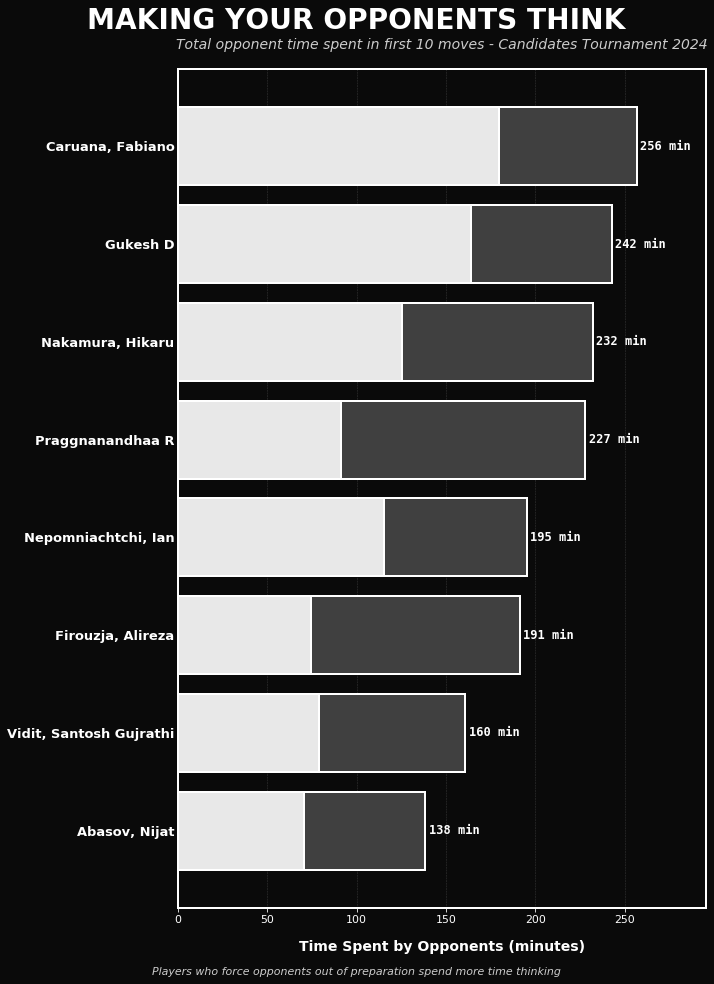

In [20]:
import chess.pgn
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import numpy as np

def parse_clock_time(clk_str):
    """Convert clock string like '1:59:58' to seconds"""
    parts = clk_str.split(':')
    if len(parts) == 3:
        hours, minutes, seconds = map(int, parts)
        return hours * 3600 + minutes * 60 + seconds
    elif len(parts) == 2:
        minutes, seconds = map(int, parts)
        return minutes * 60 + seconds
    return 0

def analyze_opponent_opening_time(pgn_file):
    """Analyze time spent by opponents in first 10 moves"""
    
    opponent_stats = defaultdict(lambda: {
        'total_opponent_time': 0,
        'vs_white_time': 0,
        'vs_black_time': 0,
        'games_as_white': 0,
        'games_as_black': 0
    })
    
    INITIAL_TIME = 120 * 60
    
    with open(pgn_file) as f:
        while True:
            game = chess.pgn.read_game(f)
            if game is None:
                break
            
            white_player = game.headers.get("White", "Unknown")
            black_player = game.headers.get("Black", "Unknown")
            
            white_time_spent = 0
            black_time_spent = 0
            
            move_count = 0
            
            for node in game.mainline():
                move_count += 1
                if move_count > 20:
                    break
                
                if node.comment and '%clk' in node.comment:
                    clk_start = node.comment.find('[%clk ') + 6
                    clk_end = node.comment.find(']', clk_start)
                    if clk_start > 5 and clk_end > clk_start:
                        clock_str = node.comment[clk_start:clk_end]
                        remaining_time = parse_clock_time(clock_str)
                        time_spent = INITIAL_TIME - remaining_time
                        
                        if move_count % 2 == 1:
                            white_time_spent = time_spent
                        else:
                            black_time_spent = time_spent
            
            opponent_stats[white_player]['total_opponent_time'] += black_time_spent
            opponent_stats[white_player]['vs_black_time'] += black_time_spent
            opponent_stats[white_player]['games_as_white'] += 1
            
            opponent_stats[black_player]['total_opponent_time'] += white_time_spent
            opponent_stats[black_player]['vs_white_time'] += white_time_spent
            opponent_stats[black_player]['games_as_black'] += 1
    
    return opponent_stats

def create_visualization(opponent_stats, output_file='opponent_time_viz.png'):
    """Create a presentation-worthy visualization"""
    
    # Prepare data
    players = []
    vs_white_times = []
    vs_black_times = []
    
    for player, stats in opponent_stats.items():
        players.append(player)
        vs_white_times.append(stats['vs_white_time'] / 60)  # Convert to minutes
        vs_black_times.append(stats['vs_black_time'] / 60)
    
    # Sort by total opponent time
    total_times = [w + b for w, b in zip(vs_white_times, vs_black_times)]
    sorted_indices = sorted(range(len(total_times)), key=lambda i: total_times[i], reverse=False)
    
    players = [players[i] for i in sorted_indices]
    vs_white_times = [vs_white_times[i] for i in sorted_indices]
    vs_black_times = [vs_black_times[i] for i in sorted_indices]
    total_times = [total_times[i] for i in sorted_indices]
    
    # Create figure with dark background for TikTok
    fig, ax = plt.subplots(figsize=(10, 14), facecolor='#0a0a0a')
    ax.set_facecolor('#0a0a0a')
    
    # Create horizontal stacked bar chart
    y_pos = np.arange(len(players))
    
    # Color scheme - chess themed
    color_vs_white = '#e8e8e8'  # Light for white pieces
    color_vs_black = '#404040'  # Dark for black pieces
    
    # Create bars
    bars1 = ax.barh(y_pos, vs_white_times, color=color_vs_white, 
                    edgecolor='#ffffff', linewidth=2, label='vs White Opponents')
    bars2 = ax.barh(y_pos, vs_black_times, left=vs_white_times, 
                    color=color_vs_black, edgecolor='#ffffff', linewidth=2, 
                    label='vs Black Opponents')
    
    # Add value labels on bars
    for i, (w, b, total) in enumerate(zip(vs_white_times, vs_black_times, total_times)):
        # Total time label at the end
        ax.text(total + 2, i, f'{int(total)} min', 
                va='center', ha='left', fontsize=12, fontweight='bold', 
                color='#ffffff', family='monospace')
    
    # Customize axes
    ax.set_yticks(y_pos)
    ax.set_yticklabels(players, fontsize=13, fontweight='bold', color='#ffffff')
    ax.set_xlabel('Time Spent by Opponents (minutes)', fontsize=14, 
                  fontweight='bold', color='#ffffff', labelpad=15)
    ax.set_xlim(0, max(total_times) * 1.15)
    
    # Grid
    ax.grid(axis='x', alpha=0.2, color='#ffffff', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Style spines
    for spine in ax.spines.values():
        spine.set_color('#ffffff')
        spine.set_linewidth(2)
    
    # X-axis ticks
    ax.tick_params(axis='x', colors='#ffffff', labelsize=11)
    ax.tick_params(axis='y', colors='#ffffff', length=0)
    
    # Title
    fig.suptitle('MAKING YOUR OPPONENTS THINK', fontsize=28, fontweight='bold', 
                 color='#ffffff', y=0.98, family='sans-serif')
    ax.set_title('Total opponent time spent in first 10 moves - Candidates Tournament 2024', 
                 fontsize=14, color='#cccccc', pad=20, style='italic')
    
    
    # Add subtitle/context
    context_text = "Players who force opponents out of preparation spend more time thinking"
    fig.text(0.5, 0.02, context_text, ha='center', fontsize=11, 
             color='#cccccc', style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(output_file, dpi=300, facecolor='#0a0a0a', bbox_inches='tight')
    print(f"Visualization saved to {output_file}")
    plt.show()

# Main execution
pgn_file = "2024-fide-candidates-chess-tournament.pgn"  # Update with your file path
opponent_stats = analyze_opponent_opening_time(pgn_file)
create_visualization(opponent_stats)